<a href="https://colab.research.google.com/github/nourhanOfTerra/MARCO/blob/main/MarCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MarCO Cubesat Transmission to the Deep Space Network Receiver on Earth

##General information 
Regarding the frequency band used for the downlink from the MARCO cubesat to the deep space network receiver on Earth. Transmission to the deep space network occurs at the X-band whose bandwidth is from 8 GHz to 12 GHz.

In [47]:
xband_BW = 8            #GHz to 12 GHz
xband_rate = 50         #to 100 Mbps
downlink_rate = 8       #kbps
carrier = 8.4*(10^9)    #8.4 GHz

##Installing and importing the necessary libraries
Mostly communication and scientific calculations packages 


In [48]:
!pip install komm
!pip install scikit-learn
!pip install scikit-commpy
!pip install pysat

In [49]:
import numpy as np
from scipy import signal as sg
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
import pandas as pd
from itertools import groupby
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
from scipy.optimize import leastsq
import pylab as pl
import scipy
import commpy 
import math
import random
import komm
import pysat

#Transmitter Side
Consists of:


*   Signal generation
*   ADC (Quantization)
*   Source encoding
*   Channel encoding
*   Digital modulation
*   Analog frontend


##Generating a simple signal

A sinusoid signal of base band frequency = 100 Hz and amplitude = 7 is chosen for illustraion. The real signal would be the telemetry signal received from the InSight lander including the current stage of entry, descent and landing, altitude and velocity of the lander.

The sampling frequency used for this signal is taken to be 100 times the baseband signal, which is much larger than Nyquist's rate, in order to avoid aliasing.



In [50]:
#Easy way out
fo = 100                            # base frequency 100 Hz
fs = 100*fo                        # sampling frequency much larger than Nyquist Rate for no aliasing
amplitude = 7                       # amplitude 5V for convention's sake
time = np.arange(0, 1, 1/fs)
signal = amplitude * np.sin(2*np.pi*fo*time)

##Plotting the signal to be transmitted
Matplotlib library is used for plotting all the signals in this notebook whether for continuous (plot) or discrete (stem) representations. The x-axis limits are defined from 0 to 0.1 s to get a clear idea of how the signal looks like. Otherwise it would be too crowded due to the relatively high frequency in reference to the size of the image as well.

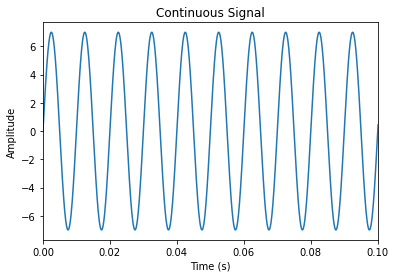

In [51]:
plt.plot(time, signal)
plt.title('Continuous Signal')
plt.xlim([0, 0.1])              #Note that the graph limits originally were from 0 to 160
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.savefig('Continuous Signal.png')

##DAC Conversion
###Sampling
The sampled signal is plotted using stem() function in Matplotlib for a discrete representation.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


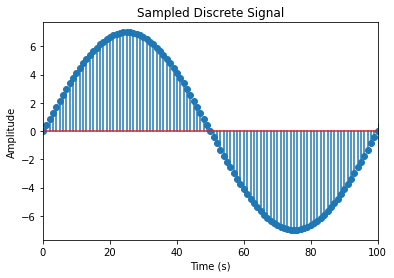

In [54]:
plt.stem(signal)
plt.title('Sampled Discrete Signal')
plt.xlim([0, 100])              
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.savefig('Sampled Discrete Signal.png')

###Quantization
Quantization is used for defining a finite number of levels for the values of the sinusoid signal. The chosen number of levels is 8 levels. The reason for this specific number is that the number of stages that the InSight lander goes through during entry, descent and landing are 8 levels:

1.   Stage separation
2.   Peak heating
3.   Peak deceleration
4.   Parachute deployment
5.   Heat shield separation
6.   Activation of the radar
7.   Terrain navigation
8.   Touch down

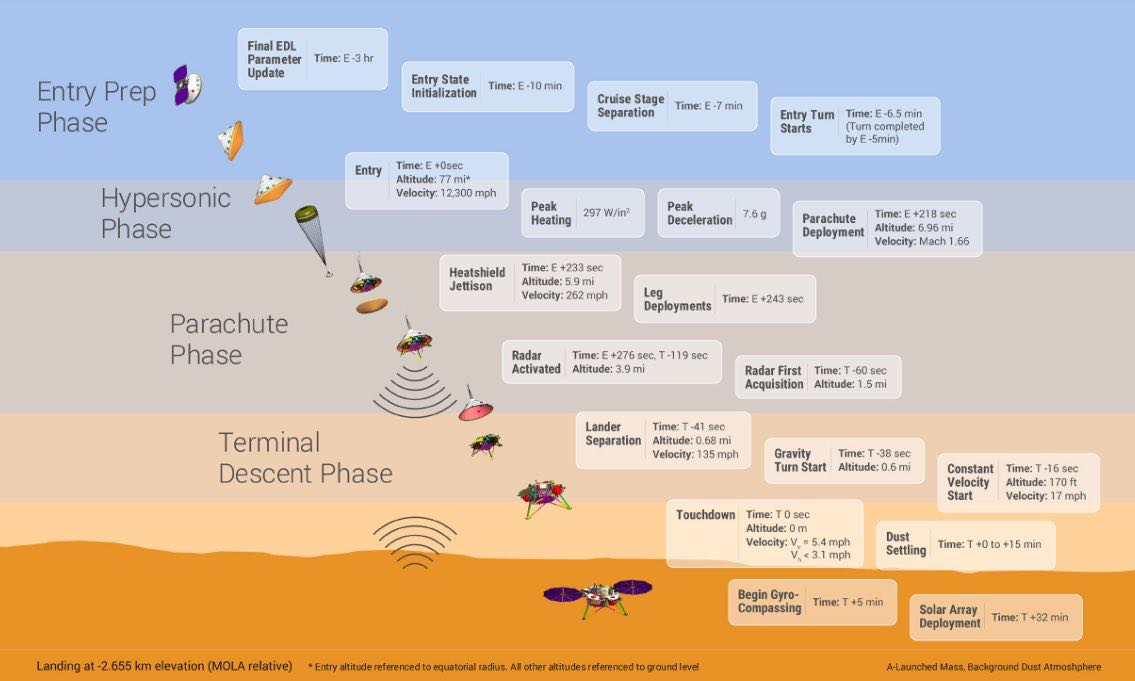

This is by no means a true representation of the EDL stages or the transmitted signal. This is just our way to try and relate the signal used for illustration with the real use case of the MARCO cubesat.

In [55]:
#Quantization Function
def quantize_uniform(x, quant_min=-1.0, quant_max=1.0, quant_level=5):
    """Uniform quantization approach

    Notebook: C2/C2S2_DigitalSignalQuantization.ipynb

    Args:
        x (np.ndarray): Original signal
        quant_min (float): Minimum quantization level (Default value = -1.0)
        quant_max (float): Maximum quantization level (Default value = 1.0)
        quant_level (int): Number of quantization levels (Default value = 5)

    Returns:
        x_quant (np.ndarray): Quantized signal
    """
    #Source: https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2S2_DigitalSignalQuantization.html
    
    x_normalize = (x-quant_min) * (quant_level-1) / (quant_max-quant_min)
    x_normalize[x_normalize > quant_level - 1] = quant_level - 1
    x_normalize[x_normalize < 0] = 0
    x_normalize_quant = np.around(x_normalize)
    x_quant = (x_normalize_quant) * (quant_max-quant_min) / (quant_level-1) + quant_min
    return x_quant

Next is the visualization of the quantized signal. As we can observe, the signal values are divided into 8 discrete levels: [-7, -5, -3, -2, -1, 1, 3, 5, 7]

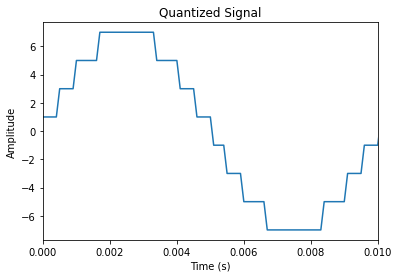

In [56]:
quantized = quantize_uniform(signal, -7, 7, 8)
plt.plot(time, quantized)
plt.xlim([0, 0.01])
plt.title('Quantized Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.savefig('Quantized Signal.png')

###Exporting the quantized signal to Excel
The reason for exporting the signal and its quantized counterpart to an Excel file is to get the exact certain levels of the quantized signal and to get a feel of what the numbers look like now.

In [57]:
data = pd.DataFrame({"Time":time, "Signal": signal, "Quantized":quantized})
data.to_excel('data.xlsx', sheet_name='sheet1', index=False)

According to the data, the quantized levels that we have are
[-7, -5, -3, -1, 1, 3, 5, 7]

It goes like this for every period: 
[1, 3, 5, 7, 5, 3, 1, -1, -3, -5, -7, -5, -3, -1]

##Source Encoding
We have chosen Fixed Length encoding for lossless encoding. Usually, Huffman encoding is used for a more efficient method. Each of the levels resulting from the quantization step is mapped to a binary sequence using a dictionary.

Before transforming the quantized signal to a binary sequence though, we need to remove the signal hold (each value is held for some time before moving to the next level). Using groupby(), only the first value at each level is retained. The only values that need to be doubled are the peaks (-7, 7), which is done using the if statement. 

In [58]:
#Hard coding the binary sequence :(
levels = [-7, -5, -3, -1, 1, 3, 5, 7]
bits_per_symbol = 3
#Setting up which value corresponds to which
encoding_dictionary = {-7: [0, 0, 0], -5: [0, 0, 1], -3: [0, 1, 0], -1: [0, 1, 1], 1: [1, 0, 0], 3: [1, 0, 1], 5: [1, 1, 0], 7: [1, 1, 1]}
#transforming the quantized signal into a "discrete" signal
discrete = [i[0] for i in groupby(quantized)]
new_discrete = []
for element in discrete:
    new_discrete.append(element)
    if element == 7 or element == -7:
        new_discrete.append(element)
discrete = new_discrete
#replacing the discrete elements with their binary codes
encoded = []
for element in discrete:
    encoded.append(encoding_dictionary[element])
#Obtaining the final binary sequence
encoded_flat = [x for l in encoded for x in l]
encoded = np.array(encoded)

##Channel Encoding
Adding redundancy to detect errors. Using SingleParityCheck from komm library. The resulting list of lists is then flattened to obtain a list of binary values in preparation for digital modulation.

In [59]:
hamming = komm.SingleParityCheckCode(encoded[0].size+1)
ch_encoded = []
for element in encoded:
    ch_encoded.append(hamming.encode(element))
ch_encoded_flat = [x for l in ch_encoded for x in l]

##Digital Modulation
Binary Phase Shift Keying (BPSK or 2PSK) is used. The carrier signal inverts its phase when the digital signal changes from one state to another (from 0 to 1 or vice versa). 

In [60]:
psk = komm.PSKModulation(2)
modulated = psk.modulate(ch_encoded_flat)

Now this is a visualization of the modulated signal using stem(). Note that the number of points is originally around 6400 points, but the plot is limited to 160 just to better distinguish some of the values.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


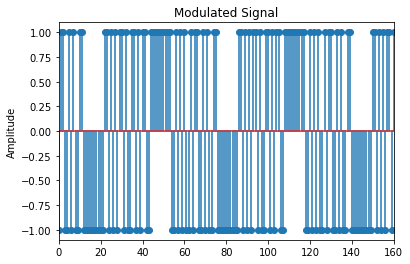

In [61]:
plt.stem(modulated)
plt.title('Modulated Signal')
plt.xlim([0, 160])              
plt.ylabel('Amplitude')
plt.savefig('BPSK modulated.png')

##Analog Frontend at the Transmitter Side
The analog frontend cosists of:


*   Upsampling
*   Pulse shaping
*   Digital to analog conversion
*   Upconversion
*   High power amplifier



###Setting up the raised cosine filter for pulse shaping

Source: [DSP Illustrations](https://dspillustrations.com/pages/posts/misc/baseband-up-and-downconversion-and-iq-modulation.html)

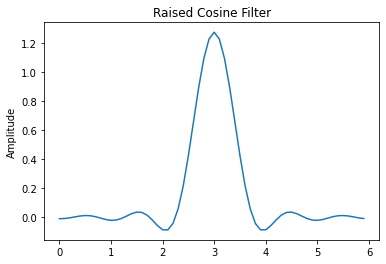

In [64]:
Fs = int(fs)            # the sampling frequency we use for the discrete simulation of analog signals
fc = int(carrier)       # 3kHz carrier frequency
Ts = 1e-3               # 1 ms symbol spacing, i.e. the baseband samples are Ts seconds apart.
BN = 1/(2*Ts)           # the Nyquist bandwidth of the baseband signal.
ups = int(Ts*Fs)        # number of samples per symbol in the "analog" domain
N = 6400                  # number of transmitted baseband samples
# the RRC filter should span 3 baseband samples to the left and to the right. 
# Hence, it introduces a delay of 3Ts seconds.
t0 = 3*Ts  
# Calculate the filter coefficients (N=number of samples in filter)
_, rrc = commpy.filters.rrcosfilter(N=int(2*t0*Fs), alpha=1,Ts=Ts, Fs=Fs)
t_rrc = np.arange(len(rrc)) / Fs  # the time points that correspond to the filter values
plt.plot(t_rrc/Ts, rrc)
plt.title('Raised Cosine Filter')
plt.ylabel('Amplitude')
plt.savefig('Raised Cosine Filter.png')

###Plotting the real and complex values of the BPSK modulated sequence

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


(0.0, 20.0)

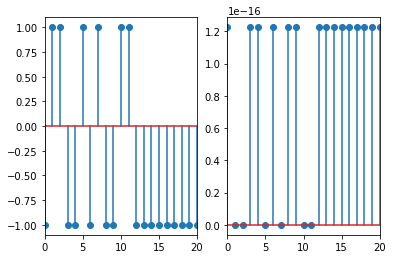

In [65]:
t_symbols = Ts * np.arange(N)                         # time instants of the baseband samples
plt.subplot(121)
plt.stem(t_symbols/Ts, modulated.real);
plt.xlim([0, 20])
plt.subplot(122)
plt.stem(t_symbols/Ts, modulated.imag);
plt.xlim([0, 20])

###Pulse shaping for the BPSK modulated sequence using the raised cosine filter

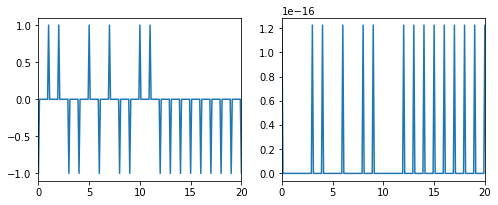

In [67]:
x = np.zeros(ups*N, dtype='complex')
x[::ups] = modulated  # every ups samples, the value of dn is inserted into the sequence
t_x = np.arange(len(x))/Fs

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(t_x/Ts, x.real);
plt.xlim([0, 20])
plt.subplot(122)
plt.plot(t_x/Ts, x.imag);
plt.xlim([0, 20])
plt.savefig('Upsampled.png')

Note that the pulse shaped signal is obtained through the convolusion of the upsampled signal with the raised cosine filter.

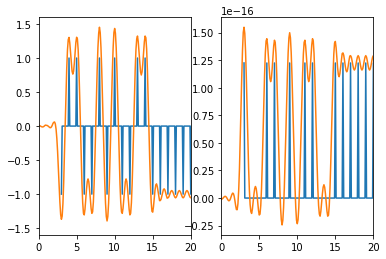

In [68]:
u = np.convolve(x, rrc)
t_u = np.arange(len(u))/Fs

plt.subplot(121)  
plt.plot((t_x+t0)/Ts, x.real, label='$x(t)$') # artificial extra delay for the baseband samples
plt.plot(t_u/Ts, u.real, label='$u(t)$')
plt.xlim([0, 20])
plt.subplot(122)
plt.plot((t_x+t0)/Ts, x.imag)
plt.plot(t_u/Ts, u.imag)
plt.xlim([0, 20])
plt.savefig('Pulse-shaped.png')

###Upconversion step
The masked signal is then upconverted by multiplying it with a cosine signal at the specified carrier frequency for the MARCO cubesat, which is 8.4 GHz.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


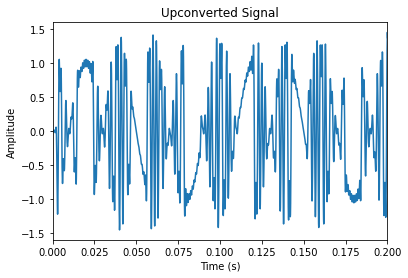

In [69]:
upconverted = np.cos(2*np.pi*fc*t_u) * u
plt.plot(t_u, upconverted)
plt.title('Upconverted Signal')
plt.xlim([0, 0.2])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.savefig('Upconverted Signal')

###High power amplifier
At this point, there should be a high power amplifier, where the measured gain of the MarCO antenna is 29.2 dBi at 8.425 GHz for the high gain antenna, 9 dBi with a 3 dB beamwidth of 20 degrees for the medium gain antenna, and of 6 dBi and a 3 dB beamwidth of approximately 60 degrees for the low gain antenna. Notw that the power amplifier is a piece of hardware that we could not model using simple python code.

#Channel
White Gaussian Noise is added to the upconverted signal to simulate the effect of the thermal noise and doppler shift in space. The function we used for the additive white gaussian noise depends on the signal to noise ratio (SNR) required at the receiver side.

To calculate the SNR, we needed to obtain the received power and the noise spectral ratio. The average received power at the deep space network receiver is around 7.943282347242822e-14 Watt. To calculate the noise spectral ratio, the system noise temperature is estimated to be 627.06052145 Kelvin using an [online calculator](https://www.everythingrf.com/rf-calculators/noise-temperature-calculator) at a reference of 290 Kelvin. For the system noise temperature to be calculated, the noise figure is needed which we found to be 5 dB maximum.

The resulting signal is then plotted using matplotlib.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


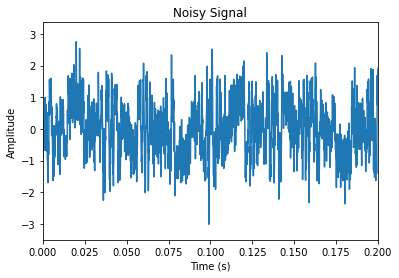

In [70]:
noise_figure = 5                                        #dB worst case scenario
Boltzmann = 1.380 * (10^-23)
system_noise_temp = 627.06052145                        #calculated at 290 kelvin reference using: https://www.everythingrf.com/rf-calculators/noise-temperature-calculator
noise_spectral_ratio = Boltzmann * system_noise_temp
average_received_power = 7.943282347242822e-14          #Average Watt for DSN
SNR = average_received_power / noise_spectral_ratio

def awgn(s,SNRdB,L=1):                                  #Source: https://www.gaussianwaves.com/2015/06/how-to-generate-awgn-noise-in-matlaboctave-without-using-in-built-awgn-function/
    """
    AWGN channel
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal 's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power spectral density N0 of noise added
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB) for the received signal
        L : oversampling factor (applicable for waveform simulation) default L = 1.
    Returns:
        r : received signal vector (r=s+n)
"""
    gamma = 10**(SNRdB/10)                              #SNR to linear scale
    if s.ndim==1:                                       # if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s)                       #Actual power in the vector
    else:                                               # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s)                  # if s is a matrix [MxN]
    N0=P/gamma                                          # Find the noise spectral density
    if isrealobj(s):                                    # check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape)         # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n                                           # received signal
    return r

noisy = awgn(upconverted, SNR)
plt.plot(t_u, noisy)
plt.title('Noisy Signal')
plt.xlim([0, 0.2])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.savefig('Noisy Signal.png')

#Receiver Side
Consists of:


*   Analog frontend
*   Digital demodulation
*   Channel decoding
*   Source decoding
*   DAC






##Analog Frontend at the Receiver Side 
Source: [DSP Illustrations](https://dspillustrations.com/pages/posts/misc/baseband-up-and-downconversion-and-iq-modulation.html)

In this part, the effects of the analog frontend of the transmitter are reversed.

###Low pass filter configuration
A low pass filter is created and configurered using the scipy library. The cutoff frequency is chosen arbitrarly to be 3 times the bandwidth of the original signal. The order of the filter is chosen arbitrarly to be 51. The filter response is then plotted in time and frequency domains using fast fourrier transform.

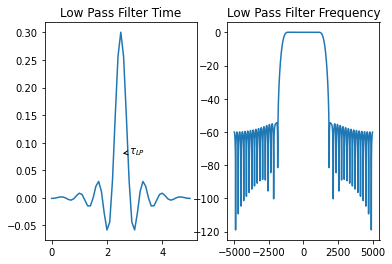

In [87]:
cutoff = 3*BN                                       # arbitrary design parameters
lowpass_order = 51   
lowpass_delay = (lowpass_order // 2)/Fs             # a lowpass of order N delays the signal by N/2 samples (see plot)
                                                    # design the filter
lowpass = sg.firwin(lowpass_order, cutoff/(Fs/2))

                                                    # calculate frequency response of filter
t_lp = np.arange(len(lowpass))/Fs
f_lp = np.linspace(-Fs/2, Fs/2, 2048, endpoint=False)
H = np.fft.fftshift(np.fft.fft(lowpass, 2048))

plt.subplot(121)
plt.plot(t_lp/Ts, lowpass)
plt.gca().annotate(r'$\tau_{LP}$', xy=(lowpass_delay/Ts,0.08), xytext=(lowpass_delay/Ts+0.3, 0.08), arrowprops=dict(arrowstyle='->'))
plt.title('Low Pass Filter Time')

plt.subplot(122)
plt.plot(f_lp, 20*np.log10(abs(H)))
plt.title('Low Pass Filter Frequency')
plt.savefig('Low Pass Filter.png')

###Downconversion
The signal is downconverted by using the previously configured low pass filter bu convolving the received noisy signal with the filter. A delay is also introduced due to the effect of the low pass filter.

In [73]:
downconverted = scipy.signal.lfilter(lowpass, 1, noisy)
y = np.convolve(downconverted, rrc) / (sum(rrc**2)) * 2
delay = int((2*t0 + lowpass_delay)*Fs)

The downconverted signal is then plotted side by side to the transmitted signal in discrete form.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this war

(0.0, 20.0)

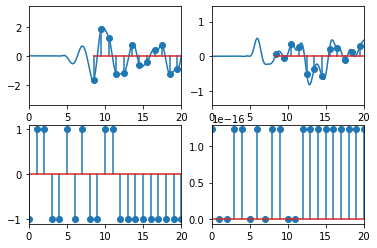

In [74]:
t_y = np.arange(len(y))/Fs
t_samples = t_y[delay::ups]
received_sampled = y[delay::ups]

plt.subplot(221)
plt.plot(t_y/Ts, y.real)
plt.xlim([0, 20])
plt.stem(t_samples/Ts, received_sampled.real)
plt.xlim([0, 20])

plt.subplot(222)
plt.plot(t_y/Ts, y.imag)
plt.xlim([0, 20])
plt.stem(t_samples/Ts, received_sampled.imag)
plt.xlim([0, 20])

plt.subplot(223)
plt.stem(t_symbols/Ts, modulated.real);
plt.xlim([0, 20])
plt.subplot(224)
plt.stem(t_symbols/Ts, modulated.imag);
plt.xlim([0, 20])


The following block is the discrete plot of the received signal after downconversion for more clarity.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


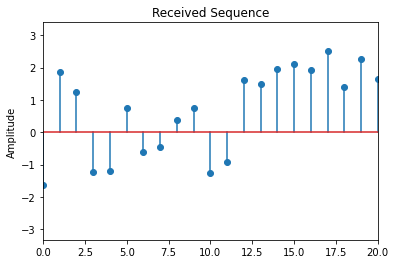

In [75]:
plt.stem(received_sampled)
plt.title('Received Sequence')
plt.xlim([0, 20])
plt.ylabel('Amplitude')
plt.savefig('Received Sequence.png')


Also, the received signal before demodulation is plotted agains the transmitted signal for comparison. It is noticed that there is an error between the transmitted signal and the received one. Potential sources for the error could be an incompatable cutoff frequency of the noise introduced in the channel, the low pass filter, or some delay in the signal combined with the previous reasons as well.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performa

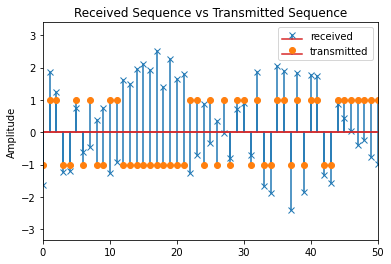

In [76]:
plt.stem(received_sampled, markerfmt='x', label='received')
plt.stem(modulated, markerfmt='o', label='transmitted')
plt.title('Received Sequence vs Transmitted Sequence')
plt.xlim([0, 50])
plt.ylabel('Amplitude')
plt.legend()
plt.savefig('Received Sequence vs Transmitted Sequence.png')

##Digital Demodulation
BPSK Demodulation using the same object created during modulation at the transmitter side. The object was created using the komm library. The demodulated signal is also plotted using matplotlib.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


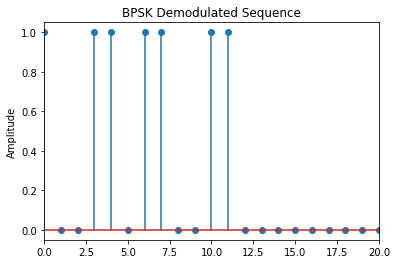

In [77]:
demodulated = psk.demodulate(received_sampled)

plt.stem(demodulated)
plt.title('BPSK Demodulated Sequence')
plt.xlim([0, 20])
plt.ylabel('Amplitude')
plt.savefig('Received Sequence.png')

##Channel Decoding
The demodulated array is then split back to form mini arrays of the sequences of the symbols. The array then become an array of arrays, where each subarray has the binary sequence of one coded symbol.

Each subarray is then decoded using the hamming code object created using komm library. The object was created at the transmitter side.

In [78]:
demodulated_divided = np.array_split(demodulated, demodulated.size/4)
ch_decoded = []
for element in demodulated_divided:
    ch_decoded.append(hamming.decode(element))

##Source Decoding
The resulting sequences from the channel decoding is then source decoded using the previously defined dictionary at the transmitter side. Each sequence is compared to the values in the dictionary and the resulting key is the one corresponding to the equivalent sequence.

In [79]:
key_list = list(encoding_dictionary.keys())
val_list = list(encoding_dictionary.values())
source_decoded = []
for element in list(ch_decoded):
    for value in val_list:
        if set(value) == set(element):
            position = val_list.index(value)
            source_decoded.append(key_list[position])

The decoded sequence should by now be the quantized levels mentioned earlier if there is no error (which is certainly not the case here). The signal is plotted for visualization.

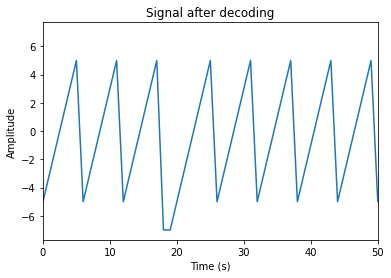

In [81]:
plt.plot(source_decoded)
plt.xlim([0, 50])
plt.title('Signal after decoding')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.savefig('Signal after decoding.png')

##Optimization
Source: https://tousu.in/qa/?qa=447771/

Since the original sinusoid could be obtained by interpolation, we decided to use an optimization algorithm to fit a sinusoid using the obtained data points. 

The first block contains the function used for this fitting, where the main optimization work is done by a function in the scipy library.

In [82]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}


The second block here is applying our results as parameters to the fitting function. The resulting final signal is then plotted in the time domain.

(0.0, 100.0)

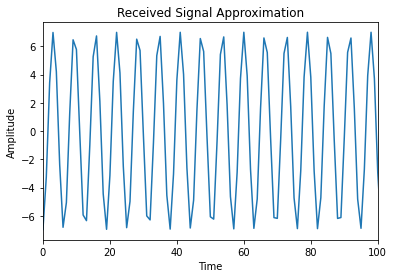

In [83]:
t = np.arange(0, np.array(source_decoded).size, 10000/fs)
fit_result = fit_sin(t, source_decoded)
amplitude = fit_result.get("amp")
omega = fit_result.get("omega")
phase = fit_result.get("phase")
offset = fit_result.get("offset")
received = 7 * np.sin(omega * t + phase) + offset

plt.plot(t, received)
plt.title('Received Signal Approximation')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.savefig('Received Signal.png')
plt.xlim([0, 100])

#Comparing transmitted and received signal
The resulting final signal is then plotted against the original signal for comparison. The most obvious difference between the two signals is that the received signal has a higher frequency than the original signal. The reason behind this discrepancy might be a runtime error in the optimization signal, or due to the previously mentioned channel induced noise.

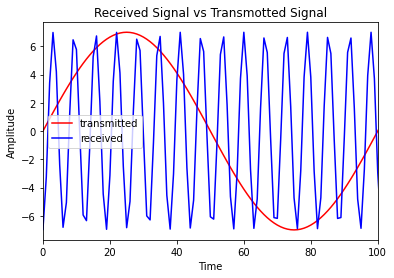

In [84]:
t1 = np.arange(0, signal.size)
plt.plot(t1, signal, color='r', label='transmitted')
plt.plot(t, received, color='b', label='received')
plt.xlim([0, 100])
plt.legend()
plt.title('Received Signal vs Transmotted Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.savefig('Received Signal vs Transmotted Signal.png')